# Introduction

This notebook covers the basic steps for fitting a machine learning model:

- Exploratory Data Analysis
- Feature Selection
- Feature Engineering and Preprocessing
- Model fitting & Evaluation
- Hyperparameter Tuning

In [1]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sbn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Plotting config
plt.rc("figure", autolayout=True)
sbn.set_theme(font="serif", font_scale=0.75)

# 1. Loading Data

For large-scale datasets, this usually involves a complex input pipeline reading in parallel from distributed data storage.

For this simple demo, we'll just fetch data using the [seaborn.load_dataset](http://seaborn.pydata.org/generated/seaborn.load_dataset.html) function.

In [2]:
mpg_data = sbn.load_dataset("mpg")
mpg_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


# 2. Exploratory Data Analysis

Exploratory data analysis reveals the characteristics / distribution of variables in the data. It helps identify necessary preprocessing steps and potential models to fit.

## 2.1 Check for Missing Values

The *horsepower* column has 6 missing values:

In [3]:
mpg_data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

Missing values are usually handled by adding an imputation step in the model pipeline. Including preprocessing logic in the model pipeline enables portability, and makes it easy to handle new input. This is how we'll proceed.

Missing values can also be dropped:

In [4]:
non_null = mpg_data.dropna()
non_null.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

## 2.2 Check for Duplicates

There are no duplicate rows.

In [5]:
mpg_data.duplicated().sum()

0

## 2.3 Get Summary Statistics

### 2.3.1 Numeric summary statistics

- Numeric values range from 3.0 to 5140.0. Normalization / standardization is recommended to rescale the variables.
- Numeric variables are positively skewed.

In [6]:
stats = mpg_data.describe(include="number").transpose()
stats["skewness"] = mpg_data.skew(numeric_only=True)
stats["kurtosis"] = mpg_data.kurtosis(numeric_only=True)
stats.style.highlight_min("min", "skyblue").highlight_max("max", "orangered")\
     .format(precision=4)

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
mpg,398.0000,23.5146,7.8160,9.0000,17.5000,23.0000,29.0000,46.6000,0.4571,-0.5108
cylinders,398.0000,5.4548,1.7010,3.0000,4.0000,4.0000,8.0000,8.0000,0.5269,-1.3767
displacement,398.0000,193.4259,104.2698,68.0000,104.2500,148.5000,262.0000,455.0000,0.7196,-0.7466
horsepower,392.0000,104.4694,38.4912,46.0000,75.0000,93.5000,126.0000,230.0000,1.0873,0.6969
weight,398.0000,2970.4246,846.8418,1613.0000,2223.7500,2803.5000,3608.0000,5140.0000,0.5311,-0.7855
acceleration,398.0000,15.5681,2.7577,8.0000,13.8250,15.5000,17.1750,24.8000,0.2788,0.4195
model_year,398.0000,76.0101,3.6976,70.0000,73.0000,76.0000,79.0000,82.0000,0.0115,-1.1812


### 2.3.2 Categorical summary statistics

- *name* has very high cardinality (305 = 76.63% unique). The most commonly ocurring name "ford pinto" appears just 6 times.

In [7]:
mpg_data.describe(include="object").transpose()

,count,unique,top,freq
origin,398,3,usa,249
name,398,305,ford pinto,6


## 2.4 Check Data Distribution

### 2.4.1 Numeric variables distribution

- *cylinders* is a discrete variable (has a finite set of possible values: 3, 4, 5, 6, and 8).
- Vehicles with 3 or 5 cylinders are extremely under-represented in the dataset. This is usually fixed by collecting more data or applying over-sampling techniques e.g. SMOTE.
- *mpg*, *displacement*, *horsepower* and *weight* are positively skewed.

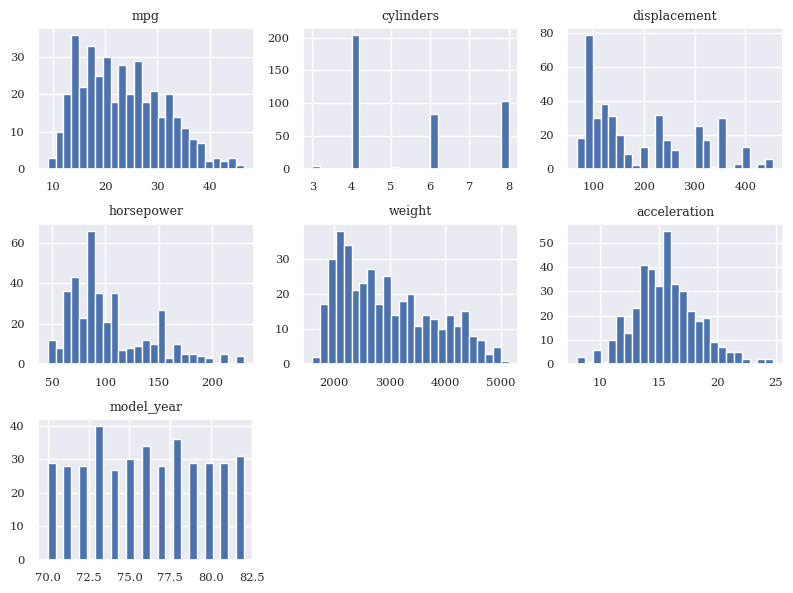

In [8]:
mpg_data.hist(bins=25, figsize=(8, 6));

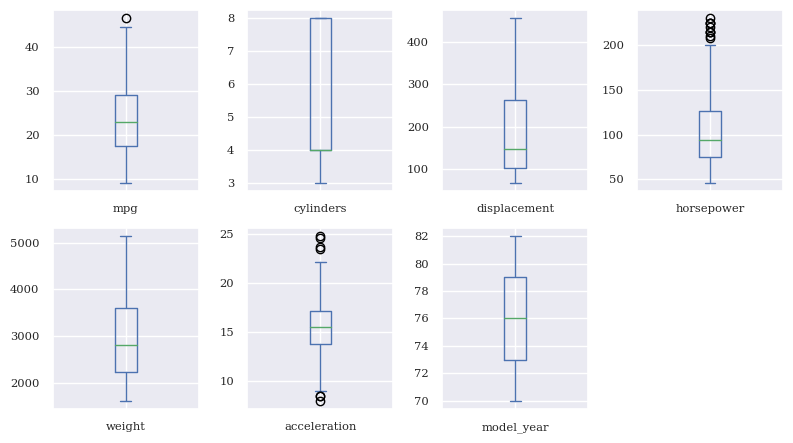

In [9]:
mpg_data.plot.box(figsize=(8, 4.5), layout=(2,4), subplots=True);

- *horsepower* and *acceleration* have a lot of outliers.

> If a pair of variables is positively correlated, an increase in one variable implies an increase in the other e.g. more processor cores => more tasks completed.
> 
> If a pair of variables is negatively correlated, an increase in one variable implies a decrease in the other e.g. higher speed => less time taken for a journey.

- *cylinders* and *displacement* have strong positive correlation (0.95)
- *displacement* and *weight* have strong positive correlation (0.93)
- *cylinders* and *weight* have strong positive correlation (0.9)
- *horsepower* and *weight* have strong positive correlation (0.86)
- *cylinders* and *horsepower* have strong positive correlation (0.84)
- *mpg* and *weight* have strong negative correlation (-0.83)
- *mpg* and *displacement* have strong negative correlation (-0.8)

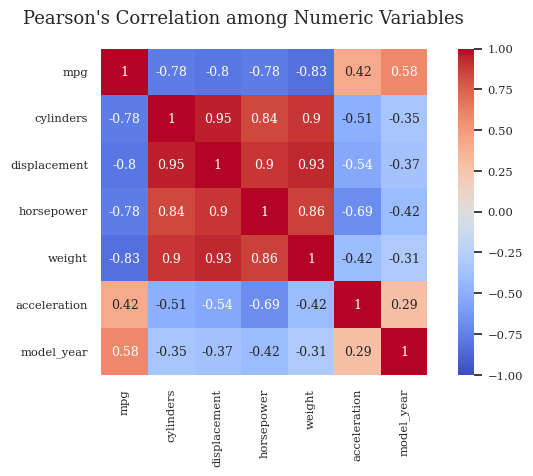

In [10]:
corr_data = mpg_data.corr(numeric_only=True)
ax = sbn.heatmap(corr_data, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True)
ax.figure.suptitle("Pearson's Correlation among Numeric Variables", size=13);

>When variables are highly correlated, a change in one variable would cause a change in another, so model results could fluctuate significantly. This can be fixed using dimension-reduction techniques like PCA.

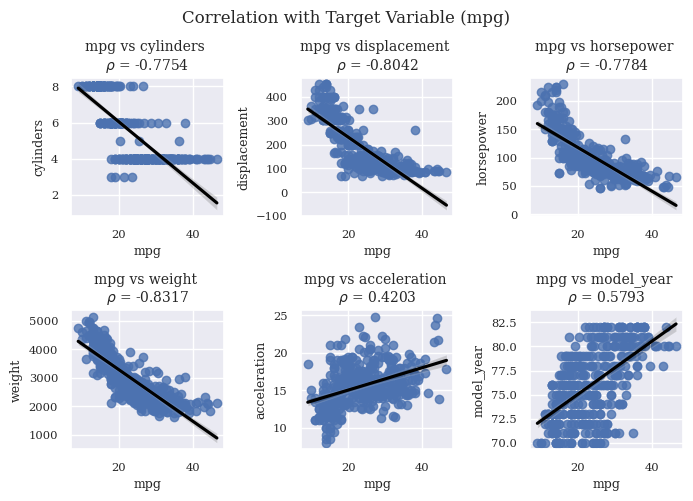

In [11]:
plt.figure(figsize=(7, 7))
for idx, col in enumerate(corr_data.drop(columns="mpg")):
    ax = plt.subplot(3, 3, idx+1)
    sbn.regplot(x=mpg_data["mpg"], y=mpg_data[col], ax=ax,
               line_kws={"color": "black"})
    ax.set_title(f"mpg vs {col} \n$\\rho$ = {corr_data.at['mpg', col]:.4f}", size=10)
    ax.figure.suptitle("Correlation with Target Variable (mpg)", size=12)

### 2.4.2 Categorical variables distribution

- Most of the vehicles are from the USA.
- Since *name* has very high cardinality (305 unique values, translating to 305 bars), only the top 10 values are plotted.

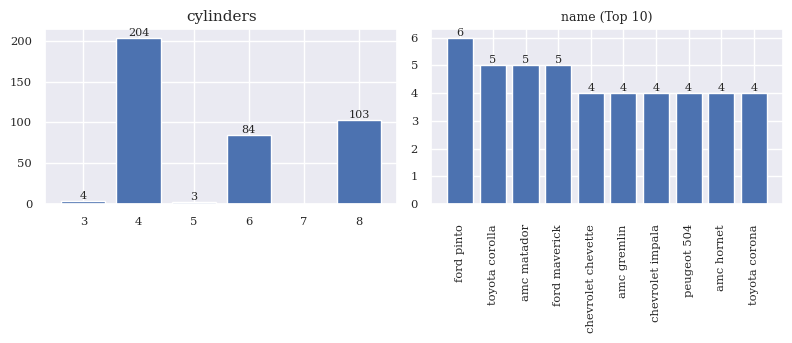

In [12]:
categorical_cols = ["cylinders", "name"]
fig, axes = plt.subplots(ncols=len(categorical_cols), figsize=(8, 3.5))
for ax, col in zip(axes.flat, categorical_cols):
    counts = mpg_data[col].value_counts()
    if len(counts) > 10:
        counts = counts.nlargest(10)
        ax.set_title(f"{col} (Top 10)")
        ax.tick_params(axis="x", rotation=90, size=11)
    else:
        ax.set_title(col, size=11)
    bars = ax.bar(counts.index, counts)
    ax.bar_label(bars, bars.datavalues, size=8)

# 3. Feature Selection

- **numeric variables:** *acceleration*, *cylinders*, *displacement*, *horsepower*, *model_year*, *weight*.
- **categorical variables:** *origin*.
- *mpg*  is the target variable.

>*name* is not used at all due to its high cardinality. Majority of the names won't have sufficient examples, which could lead to overfitting (memorizing examples instead of the general pattern).

In [13]:
numeric_vars = ["acceleration", "cylinders", "displacement", "horsepower",
                "model_year", "weight"]
categorical_vars = ["origin"]

X = mpg_data[numeric_vars + categorical_vars]
y = mpg_data["mpg"]

> To ensure reproducibility of results, it is recommended to "set the seed" for random operations. *scikit-learn* objects that contain randomness allow this with the `random_state` argument.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# 4. Feature Engineering / Preprocessing

- Numeric variables are passed through an imputer to fill missing values with the median. Afterwards, they're standardized.
- Categorical variables are passed through an imputer to fill missing values with the mode. Afterwards, they're one-hot encoded.

In [15]:
numeric_preprocessor = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler()
)
categorical_preprocessor = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder()
)                                                       
preprocessor = ColumnTransformer([
    ("numeric", numeric_preprocessor, numeric_vars),
    ("categorical", categorical_preprocessor, categorical_vars)
])

# 5. Model fitting & Evaluation

## 5.1 Base Model

It is often useful to fit a base model with default settings in order to get a baseline score for benchmarking.

In [16]:
base_model = make_pipeline(preprocessor, 
                           RandomForestRegressor(random_state=3))
base_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['acceleration', 'cylinders',
                                                   'displacement', 'horsepower',
                                                   'model_year', 'weight']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['origin'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=3))])

In [17]:
def compute_metrics(model: RandomForestRegressor) -> None:
    """Calculate and display the R2 score, mean absolute error and mean
    squared error.

    Args:
        model (RandomForestRegressor): A fitted sklearn random forest model.
    """
    print(
        f"R2 Score: {model.score(X_test, y_test):.4f}\n"
        f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.4f}\n"
        f"MSE: {mean_squared_error(y_test, model.predict(X_test)):.4f}"
    )


compute_metrics(base_model)

R2 Score: 0.8735
MAE: 1.9482
MSE: 7.9360


## 5.2 Hyperparameter Tuning

Hyperparameters are arguments/parameters that define a model's structure and configuration. They have to be set before a model is trained.

Hyperparameter tuning seeks to find the set of hyper-parameters that yield the best test score on the evaluation metric.

In [ ]:
model = make_pipeline(preprocessor, RandomForestRegressor(random_state=3))
params = {
    "randomforestregressor__n_estimators": [100, 200],
    "randomforestregressor__max_depth": [3, 5, 7],
    "randomforestregressor__min_samples_leaf": [1, 3, 0.01]
}
random_search = GridSearchCV(model, params, cv=4)
best_model = random_search.fit(X_train, y_train)
print(best_model.best_params_)
compute_metrics(best_model)

{'randomforestregressor__max_depth': 7, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 200}
R2 Score: 0.8780
MAE: 1.9151
MSE: 7.6568


Compared to our benchmark score, the tuned model has:

- Slightly higher R2 score (0.8735 -> 0.8780). Higher is better.
- Slightyly lower MAE (1.9482 -> 1.9151) and MSE (7.9360 -> 7.6568). Lower is better.

These scores can probably be improved by exploring more combinations of parameters and trying a different type of model.


# 6. Model Deployment

You can use the `joblib` package to persist your model pipeline as a file. This file can then be loaded in a web server or any other deployment environment with the required dependencies e.g.

- A [Flask][flask] app
- A [streamlit][streamlit] app
- [FastAPI][fastapi]

[flask]: https://flask.palletsprojects.com/en/2.3.x/
[streamlit]: https://streamlit.io/
[fastapi]: https://fastapi.tiangolo.com/

In [19]:
joblib.dump(best_model, "model.xz")

['model.xz']

In [20]:
loaded_model = joblib.load("model.xz")
compute_metrics(loaded_model)

R2 Score: 0.8780
MAE: 1.9151
MSE: 7.6568


In [21]:
pd.DataFrame({"Actual": y_test.head(),
              "Predicted": loaded_model.predict(X_test.head())})

,Actual,Predicted
94,13.0,12.534082
32,25.0,25.685227
279,29.5,33.281642
178,23.0,21.445193
354,34.5,32.584491
